# Random Forest Classification

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import additional dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import time

# Ignore Python warnings about past model versions
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import datasets
X_train_cluster = pd.read_csv("data/X_train_cluster.csv", index_col = 0)
X_test_cluster = pd.read_csv("data/X_test_cluster.csv", index_col = 0)
y_train = pd.read_csv("data/y_train.csv", index_col = 0)
y_test = pd.read_csv("data/y_test.csv", index_col = 0)

## Cross-Validation to Determine Optimal Classifier Hyperparameters

In [3]:
# Define a parameter grid of hyperparameters
param_grid = {
    "n_estimators" : [50, 100, 200, 300, 500],
    "max_depth" : [None, 10, 20, 30],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False]
}

In [4]:
# Create a RandomForestClassifier model
random_forest = RandomForestClassifier()
start = time.time()

# Create a GridSearchCV object to perform Grid Search
grid_search = GridSearchCV(random_forest, param_grid, cv = 5, scoring = "accuracy", n_jobs = -1)
# Fit the GridSearchCV object onto the dataset
grid_search.fit(X_train_cluster, y_train)

# Get and display the best parameters and scores from hyperparamater grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

end = time.time()
train_time = end - start
# Display how long it took the model to train
print(f"Total Training Time: {train_time:.2f}\n")

print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Total Training Time: 2554.89

Best parameters:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation score:  0.5673555555555556


From the model we can determine that the **best hyperparameters** to use within training our Random Forest Classifier is a Forest with **maximum depth** of **10**, **minimum numper of samples required to be at a leaf node** of **4**, **minimum number of samples required to split an internal node** to be **10**, with **500 trees in the forest** and sub-sample size being inherently controlled **(sub-samples of dataset used to build each individual tree)**. Additionally we have determined with these model hyperparameters the Random Forest Classifier will have a cross-validation score of **0.567**.

## Training a Random Forest Classifer

In [5]:
# Create the RandomForestModel
forest = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_leaf = 4,
                               min_samples_split = 10, bootstrap = True)
start = time.time()

# Train the model
forest.fit(X_train_cluster, y_train)

end = time.time()
train_time = end - start
# Display how long it took the model to train
print(f"Total Training Time: {train_time:.2f}")

# Use trained model to make predictions on the test dataset
y_pred = forest.predict(X_test_cluster)

Total Training Time: 24.23


In [6]:
# Print the classification report
print(classification_report(y_test, y_pred))

# Store classification report into a variable
report = classification_report(y_test, y_pred, output_dict = True)

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       500
           1       0.77      0.72      0.74       500
           2       0.41      0.59      0.48       500
           3       0.44      0.18      0.26       500
           4       0.55      0.62      0.59       500
           5       0.41      0.36      0.38       500
           6       0.59      0.47      0.53       500
           7       0.48      0.75      0.59       500
           8       0.84      0.80      0.82       500
           9       0.44      0.42      0.43       500

    accuracy                           0.55      5000
   macro avg       0.56      0.55      0.54      5000
weighted avg       0.56      0.55      0.54      5000



In [7]:
# Display the original mapping of genres
genre_map = {'Electronic': 0, 'Anime': 1, 'Jazz': 2, 'Alternative': 3, 'Country': 4, 
             'Rap': 5, 'Blues': 6, 'Rock': 7, 'Classical': 8, 'Hip-Hop': 9}
genre_map.items()

dict_items([('Electronic', 0), ('Anime', 1), ('Jazz', 2), ('Alternative', 3), ('Country', 4), ('Rap', 5), ('Blues', 6), ('Rock', 7), ('Classical', 8), ('Hip-Hop', 9)])

In [8]:
# Convert classification report into a DataFrame
forest_report = pd.DataFrame(report).transpose()

# Replace index of DataFrame with genre names
genre_map_inverted = {str(v): k for k,v in genre_map.items()}
forest_report.index = [genre_map_inverted.get(i,i) for i in forest_report.index]

# Sort the DataFrame by precision 
forest_report = forest_report.sort_values(by = "precision", ascending = False)
forest_report

,precision,recall,f1-score,support
Classical,0.840000,0.7980,0.818462,500.0000
Anime,0.769892,0.7160,0.741969,500.0000
Electronic,0.648230,0.5860,0.615546,500.0000
Blues,0.594458,0.4720,0.526198,500.0000
macro avg,0.557432,0.5508,0.542904,5000.0000
weighted avg,0.557432,0.5508,0.542904,5000.0000
Country,0.553191,0.6240,0.586466,500.0000
accuracy,0.550800,0.5508,0.550800,0.5508
Rock,0.481434,0.7520,0.587041,500.0000
Hip-Hop,0.437500,0.4200,0.428571,500.0000


## One vs Rest Multi-Class Classification AUC and ROC Evaluation

In [9]:
# Import additional dependencies
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

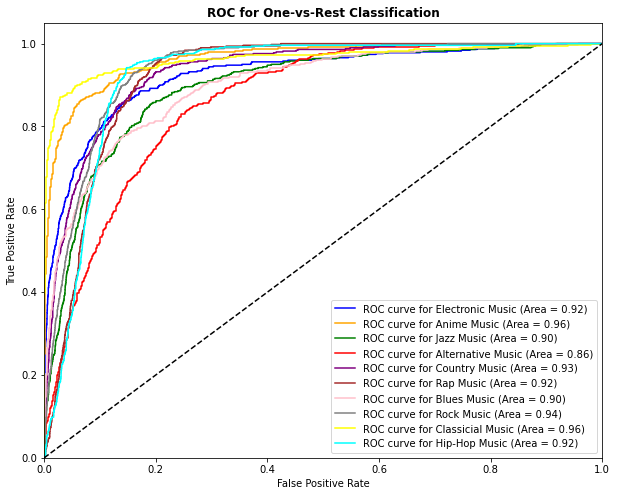

In [10]:
# Create list of labels with corresponding classes
labels = [("Electronic", 0), ("Anime", 1), ("Jazz", 2), ("Alternative", 3), ("Country", 4),
         ("Rap", 5), ("Blues", 6), ("Rock", 7), ("Classicial", 8), ("Hip-Hop", 9)]

# Binarize the labels
y = label_binarize(y_test, classes = [0,1,2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

# One-vs-all to predict classes
classifier = OneVsRestClassifier(forest)
y_score = classifier.fit(X_train_cluster, y_train).predict_proba(X_test_cluster)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for the classifier
plt.figure(figsize = (10,8))
colors = cycle(["blue", "orange", "green", "red", "purple",
                "brown", "pink", "gray", "yellow", "cyan"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color,
             label='ROC curve for {0} Music (Area = {1:0.2f})'
             ''.format(labels[i][0], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for One-vs-Rest Classification", fontweight = "bold")
plt.legend(loc = "lower right")
plt.show();

## Calculating Macro-Average AUC of Model

In [11]:
# Import additional dependencies
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

# Define a function which will calulcate macro-average of AUC score
def macro_average_auc(y_test, y_pred, average = "macro"):
    label = LabelBinarizer()
    label.fit(y_test)
    y_test = label.transform(y_test)
    y_pred = label.transform(y_pred)
    
    return roc_auc_score(y_test, y_pred, average = average)

In [12]:
# Calculate and display final macro-averaged AUC score
auc = macro_average_auc(y_test, y_pred)
print(f"Macro-Average AUC Score of Model: {auc:5f}")

Macro-Average AUC Score of Model: 0.750444
